# Neural style transfer 

In [1]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def get_image(path, img_transform, size=(300, 300)):
    image = Image.open(path)
    image = image.resize(size, Image.LANCZOS)
    image = img_transform(image).unsqueeze(0)
    return image.to(device)

def get_gram(m):
    """
    m is of shape (1, C, H, W)
    """
    _, c, h, w = m.size()
    m = m.view(c, h * w)
    m = torch.mm(m, m.t())
    return m


def denormalize_img(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

In [3]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.selected_layers = [3, 8, 15, 22]
        self.vgg = models.vgg16(pretrained = True).features
        
    def forward(self, x):
        layer_feats = []
        for layer_num, layer in self.vgg._modules.items():
            x = layer(x)
            if int(layer_num) in self.selected_layers:
                layer_feats.append(x)
        return layer_feats
        

In [4]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225))
])

content_img = get_image('/kaggle/input/neural-style-transfer-images/m2.jpg', img_transform)
style_img = get_image('/kaggle/input/neural-style-transfer-images/picasso.jpg', img_transform)

generated_img = content_img.clone()
generated_img.requires_grad = True

optimizer = torch.optim.Adam([generated_img], lr=0.003, betas=[0.5, 0.999])
encoder = FeatureExtractor().to(device)

for p in encoder.parameters():
    p.requires_grad = False

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 231MB/s]


In [5]:
content_weight = 1
style_weight = 100

for epoch in range(500):
    
    content_features = encoder(content_img)
    style_features = encoder(style_img)
    generated_features = encoder(generated_img)
    
    content_loss = torch.mean((content_features[-1] - generated_features[-1])**2)
    
    style_loss = 0
    for gf, sf in zip(generated_features, style_features):
        _, c, h, w = gf.size()
        gram_gf = get_gram(gf)
        gram_sf = get_gram(sf)
        style_loss+= torch.mean((gram_gf - gram_sf)**2)/(c*h*w)
        
    loss = content_weight * content_loss + style_weight * style_loss 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}]\tContent Loss: {content_loss.item()}\tstyle loss: {style_loss.item()}")

Epoch [0]	Content Loss: 0.0	style loss: 372.1954650878906
Epoch [10]	Content Loss: 0.4433128535747528	style loss: 259.5769958496094
Epoch [20]	Content Loss: 0.7972067594528198	style loss: 211.84536743164062
Epoch [30]	Content Loss: 1.055768370628357	style loss: 180.80653381347656
Epoch [40]	Content Loss: 1.2630473375320435	style loss: 157.9132537841797
Epoch [50]	Content Loss: 1.4303028583526611	style loss: 140.08486938476562
Epoch [60]	Content Loss: 1.5752339363098145	style loss: 125.75078582763672
Epoch [70]	Content Loss: 1.7019712924957275	style loss: 113.975341796875
Epoch [80]	Content Loss: 1.810969591140747	style loss: 104.14271545410156
Epoch [90]	Content Loss: 1.9088369607925415	style loss: 95.81338500976562
Epoch [100]	Content Loss: 1.9951679706573486	style loss: 88.66934204101562
Epoch [110]	Content Loss: 2.0726265907287598	style loss: 82.47809600830078
Epoch [120]	Content Loss: 2.1450536251068115	style loss: 77.07830810546875
Epoch [130]	Content Loss: 2.210583448410034	style

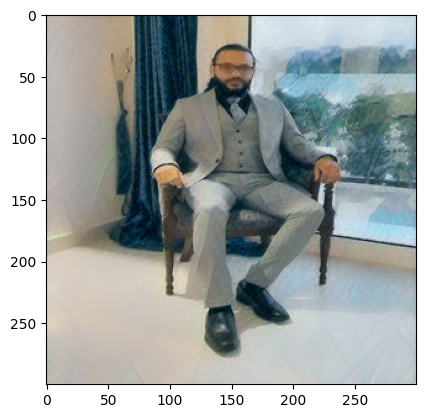

In [6]:
inp = generated_img.detach().cpu().squeeze()
inp = denormalize_img(inp)
plt.imshow(inp)